In [59]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

In [10]:
from NoiseKD import Teacher,ToyTransformer, count_parameters

First hurdle. the embedding layer.  It requires the ints as inputs, not one hot.  i need one hot.  i will also need to rewire the LLM i use to do the same.  hmm.  save the weights, load it into a model that has the same shapes, but accepts one hot arrays, not vocab_indexes.

In [11]:
embedding_dim = 16
num_heads = 8
hidden_dim  = 11
num_layers = 2
dropout = 0.1
vocab_size = 80
class_num = vocab_size
batch_size = 50
sequence_length = 160

In [12]:
TT = ToyTransformer(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, dropout,sequence_length)

In [13]:
count_parameters(TT)

215702

In [31]:
teacher_toy = Teacher(TT,(sequence_length,)) #don't specify batch!!

In [33]:
##some of these configs made for more diverse outputs in teachers:
config_args = {"dist_type" : "ints" ##worked well
                      , "gen_m" : vocab_size
                      , "gen_n" : 100
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.001
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_high_epochs = {"dist_type" : "ints" ##okay, but not as well as config_args.
                      , "gen_m" : vocab_size
                      , "gen_n" : 1000
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.001
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_higher_lr = {"dist_type" : "ints" ##lower was worse.  raise it. 0.003 looks great.  this is the best.
                      , "gen_m" : vocab_size
                      , "gen_n" : 2000
                      , "gen_epochs" : 50
                      , "gen_lr" :  0.003 ##0.003
                      , "random_shuffle" : 0.8
                      , "out_type" : "one-hot" }

config_args_less_data = {"dist_type" : "ints" ##worse
                      , "gen_m" : vocab_size
                      , "gen_n" : 500
                      , "gen_epochs" : 100
                      , "gen_lr" : 0.003
                      , "random_shuffle" : 0.1
                      , "out_type" : "one-hot" }

config_args_high_shuffle = {"dist_type" : "ints" ##one bar..
                      , "gen_m" : vocab_size
                      , "gen_n" : 10_000
                      , "gen_epochs" : 10
                      , "gen_lr" : 0.05
                      , "random_shuffle" : 0.9
                      , "out_type" : "one-hot" }

config_args_small_batch = {"dist_type" : "ints" ##this one was the first to do well.  not just one bar and the rest nearly zero.
                      , "gen_m" : vocab_size
                      , "gen_n" : 10_000
                      , "gen_epochs" : 10
                      , "gen_lr" : 0.05
                      , "random_shuffle" : 0.5
                      , "batch_size" : 10
                      , "out_type" : "one-hot" }

config_ab = {"dist_type" : "ints" ##worked well
                      , "gen_m" : vocab_size
                      , "gen_n" : 5000
                      , "gen_epochs" : 200
                      , "gen_lr" : 0.005
                      , "random_shuffle" : 0.0
                      , "out_type" : "one-hot" 
                      , "dist_type" : 'hetero'
                      , "alpha" : 1
                      , "beta" : 4} #maybe increase epochs?

In [39]:
#teacher_toy.configure(**config_ab) #this is dying.  might be time for colab!!
teacher_toy.load_state_dict('good_toy.pth')

Expected tensor for argument #1 'indices' to have one of the following scalar types: Long, Int; but got torch.FloatTensor instead (while checking arguments for embedding)
lets try ints!


In [40]:

args = { 'val_train' : "val"
                      , 'n' : 1000
                      , 'dist_type' : 'ints'
                      , 'm' : vocab_size
                      , 'std': 1.0
                      , 'batch_size' : 50
                      , 'store_outputs': True
        }
teacher_toy.generate_data(**args)


Generating val data ::   0%|                             | 0/20 [00:00<?, ?it/s]


In [41]:
teacher_toy.model.embedding.weight.detach().numpy() #use this to make the matrix, just linear? not sure.

array([[ 0.13697533,  1.0160749 ,  0.42515135, ...,  2.1265104 ,
         0.01124284, -1.2953788 ],
       [ 0.59546024, -0.99750274,  1.1170036 , ..., -1.6646637 ,
         0.45393214, -0.55875623],
       [ 0.6230322 ,  0.17974639,  0.8337519 , ...,  0.78358537,
        -0.32227072, -0.48803455],
       ...,
       [ 0.06030137, -0.20708236,  1.5042213 , ..., -1.0101138 ,
        -0.70308393, -0.0137438 ],
       [ 0.17904644, -0.83012843,  0.9453919 , ...,  0.38582733,
         0.7353223 , -0.42883456],
       [-2.56302   ,  0.89828813, -0.46527362, ...,  0.16203569,
        -0.34777856,  0.22505838]], dtype=float32)

Configuring Teacher::   4%|▊                  | 8/200 [03:23<1:21:18, 25.41s/it]


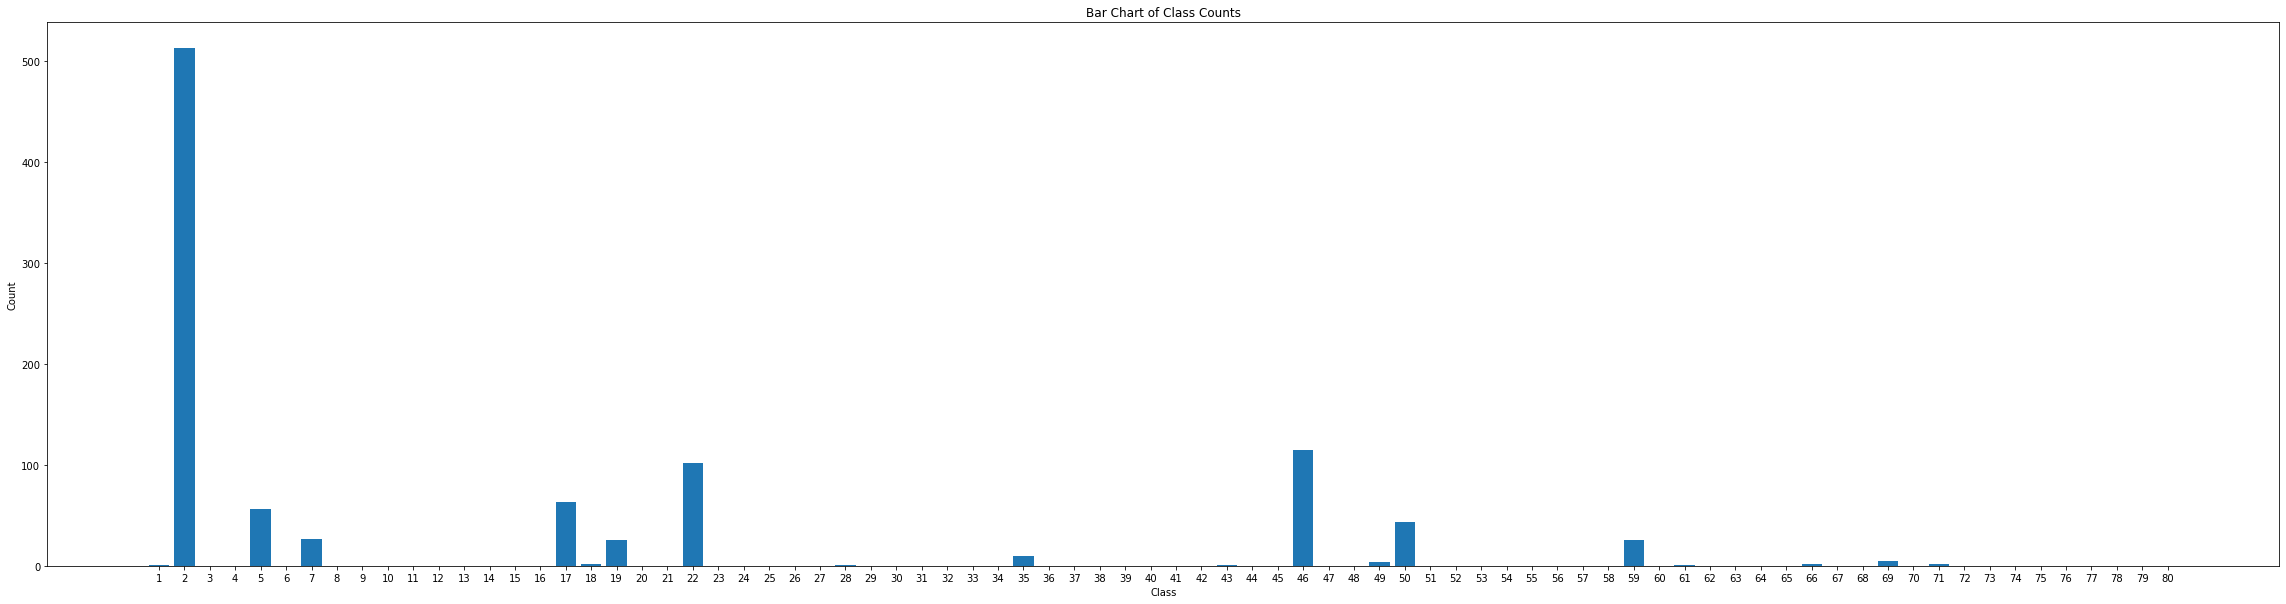

In [42]:
teacher_toy.graph_dataset_dist()

In [47]:
teacher_toy.val_inputs.shape,teacher_toy.val_targets.shape

(torch.Size([1000, 160]), torch.Size([1000, 80]))

In [ ]:
teacher_slm.val_inputs.shape, teacher_slm.val_targets.shape

In [ ]:
torch.all(teacher_slm.model(teacher_slm.val_inputs[1]) ==  teacher_slm.val_targets[1]) ##torch.allclose doesn't work either

In [48]:
##this function works, it is in LABNET.  
def one_hot_last_dim(tensor_shape):
    num_classes = tensor_shape[-1]
    random_idx = np.random.randint(1, num_classes + 1, size=tensor_shape[:-1])
    zero_tensor = np.zeros(tensor_shape, dtype=int)
    last_dim_indices = np.arange(num_classes)
    zero_tensor[..., :, last_dim_indices] = (random_idx[..., np.newaxis] == last_dim_indices)
    return zero_tensor

In [49]:
from torch.optim.lr_scheduler import LambdaLR
import math

warmup_steps = 60_000  # Adjust this as needed steps is total items passed through
total_steps = 200_000  # Adjust this as needed i'd like to calculate this....


# Define a learning rate scheduler with warmup
def lr_lambda(current_step):
    if current_step < warmup_steps:
        # During warmup, increase learning rate linearly
        return float(current_step) / float(max(1, warmup_steps))
    else:
        # After warmup, decrease learning rate using some schedule
        # You can use any LR schedule you prefer here
        # For example, you can use a learning rate schedule like CosineAnnealing
        return 0.5 * (1 + math.cos(math.pi * (current_step - warmup_steps) / (total_steps - warmup_steps)))



""" Training loop
for step in range(total_steps):
    optimizer.zero_grad()
    # Compute your loss and backpropagation here
    loss.backward()
    optimizer.step()
    scheduler.step()
"""

' Training loop\nfor step in range(total_steps):\n    optimizer.zero_grad()\n    # Compute your loss and backpropagation here\n    loss.backward()\n    optimizer.step()\n    scheduler.step()\n'

In [53]:
student = ToyTransformer(vocab_size, embedding_dim, num_heads, hidden_dim, num_layers, dropout,sequence_length)

In [62]:
#############non-repeating train
learning_rate = 0.001 #0.00025 this shit is slooooow
momentum = 0.95
val_batch_size = 10


num_epochs = 50
batches_per_epoch = 100
batch_size = 1000
data_per_batch = batch_size

criterion =  nn.MSELoss() #nn.KLDivLoss() #nn.CrossEntropyLoss()  #i think stick to mse for now.  this probs just needs lots of time to start learning.  like s4 lol.
optimizer = optim.Adam(student.parameters(), lr=learning_rate)
#scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
#optimizer = optim.SGD(student.parameters(), lr=learning_rate, momentum=momentum)
#no train data loader here.
val_data = list(zip(teacher_toy.val_inputs, teacher_toy.val_targets))
val_input_tensors = torch.stack([torch.Tensor(x[0]) for x in val_data])
val_target_tensors = torch.stack([torch.Tensor(x[1]) for x in val_data])
val_dataset = TensorDataset(val_input_tensors, val_target_tensors)
val_dataloader = DataLoader(val_dataset, batch_size=val_batch_size, shuffle=True)
accuracy_threshold = 0.5
print_every = 1 #its working, its just lots of data mama.
validation_every = 1


gen_args  = { 'val_train' : "train"
              , 'n' : data_per_batch
              , 'dist_type' : 'ints' #this is generating ints for inputs, the outputs are logits.  hmmmm
              , 'm' : vocab_size
              , 'std': 1.0
              , 'display_progress' : False
              , 'store_outputs' : True
        }

losses = []  # List to store losses
accuracies = []

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

student = student.to(device)
for epoch in range(num_epochs):
    student.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    for i in range(batches_per_epoch):
        optimizer.zero_grad()  # Zero the gradients

        teacher_toy.generate_data(**gen_args)
        data_e = list(zip(teacher_toy.train_inputs, teacher_toy.train_targets))
        input_tensors_e = torch.stack([torch.Tensor(x[0]) for x in data_e])
        target_tensors_e = torch.stack([torch.Tensor(x[1]) for x in data_e])
        dataset_e = TensorDataset(input_tensors_e, target_tensors_e)
        dataloader_e = DataLoader(dataset_e, batch_size=batch_size, shuffle=True)

        for input_batch_e, target_batch_e in dataloader_e:
            optimizer.zero_grad()  # Zero the gradients
            input_batch_e = input_batch_e.to(device)
            target_batch_e = target_batch_e.to(device)
            output = student(input_batch_e)  # Forward pass
            loss = criterion(output, target_batch_e)  # Compute the loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Update the weights

            #scheduler.step() ##this does the warmup step.  

            total_loss += loss.item()
            #add early stopping...
            #and validation at each step.
            # Calculate accuracy
            predictions = (output > accuracy_threshold).float()  # Assuming a threshold of 0.5 for binary classification
            correct_predictions += (predictions == target_batch_e).sum().item()
            total_samples += input_batch_e.size(0)

    # Print the average loss for this epoch
    avg_loss = total_loss / ( batches_per_epoch * data_per_batch)
    losses.append(avg_loss)

    accuracy = correct_predictions / total_samples
    accuracies.append(accuracy)

    if (epoch + 1) % print_every == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss}, Train Accuracy: {accuracy:.4f}')
        current_lr = optimizer.param_groups[0]['lr']
        print(current_lr)
    
    if (epoch + 1) % validation_every == 0:
        student.eval()

        total_val_samples = 0
        correct_val_predictions = 0

        with torch.no_grad():
            for val_input_batch, val_target_batch in val_dataloader:
                val_input_batch = val_input_batch.to(device)
                val_target_batch = val_target_batch.to(device)
                val_output = student(val_input_batch)
                val_predictions = (val_output > accuracy_threshold).float()  # Assuming a threshold of 0.5 for binary classification
                correct_val_predictions += (val_predictions == val_target_batch).sum().item()
                total_val_samples += val_input_batch.size(0)

        # Calculate validation accuracy
        val_accuracy = correct_val_predictions / total_val_samples

        # Print the validation accuracy for this epoch
        print(f'\t\tValidation Accuracy: {val_accuracy:.4f}')

        # Set the model back to training mode
        student.train()


KeyboardInterrupt: 